In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.svm import SVR
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import *
from random import seed
from scipy import stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
%matplotlib inline

seed(888)

Load data

In [81]:
# load data from pickle and convert to dataframe
brain_test = pd.read_pickle("2_brain_test.pkl")
brain_train = pd.read_pickle("2_brain_train.pkl")
main_test = pd.read_pickle("2_main_test.pkl")
main_train = pd.read_pickle("2_main_train.pkl")
main_test_all = pd.read_pickle("2_main_test_all.pkl")
brain_test_all = pd.read_pickle("2_brain_test_all.pkl")
brain_test = pd.DataFrame(brain_test)
brain_train = pd.DataFrame(brain_train)
main_test = pd.DataFrame(main_test)
main_train = pd.DataFrame(main_train)
main_test_all = pd.DataFrame(main_test_all)
brain_test_all = pd.DataFrame(brain_test_all)

Select either with excluded people (_all) or without (main_test)

In [82]:
main_test = main_test_all
brain_test = brain_test_all


Delete rows with nan in any brain segmentation variable

In [83]:

nan_all_test = brain_test[brain_test.iloc[:,1:2544:2].isnull().any(axis=1)].index
nan_all_train = brain_train[brain_train.iloc[:,1:2544:2].isnull().any(axis=1)].index
main_test = main_test.drop(nan_all_test)
main_train = main_train.drop(nan_all_train)
brain_test = brain_test.drop(nan_all_test)
brain_train = brain_train.drop(nan_all_train)

print("Number of people with missing brain values in train set:", len(nan_all_train))
print("Number of people with missing brain values in test set:", len(nan_all_test))

Number of people with missing brain values in train set: 42
Number of people with missing brain values in test set: 20


# 1. A2009s Segmentation (Thickness and Area)

In [84]:
a2009s_train = brain_train.iloc[:,1657:2544:2]
a2009s_test = brain_test.iloc[:,1657:2544:2]
age_train = brain_train["Age"]
age_test = brain_test["Age"]
a2009s_train = pd.concat([a2009s_train,age_train],axis = 1)
a2009s_test = pd.concat([a2009s_test,age_test],axis = 1)


X_train = brain_train.iloc[:,1657:2544:2]
Y_train = brain_train.iloc[:,-1]
X_test = brain_test.iloc[:,1657:2544:2]
Y_test = brain_test.iloc[:,-1]

### Cross validation

In [85]:
# set of alphas to try (=penalization)
alpha_parameters = np.power(10,np.linspace(start=-3, stop=5, num=100))

# standardize x-data
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.fit_transform(X_test)

# Cross validation
# cross validation on training set only -> select training set
X_CV = X_train_std
Y_CV = Y_train
# randomly split data (only training no PA) into training and testing set
X_train_cv, X_test_cv, Y_train_cv, Y_test_cv = train_test_split(X_CV,Y_CV, random_state=8)
model = RidgeCV(alphas = alpha_parameters)
model.fit(X_train_cv,Y_train_cv)
y_pred_cv = model.predict(X_test_cv)
delta_cv = y_pred_cv - Y_test_cv
print("The MAE for cross-validation (Ridge):", mean_absolute_error(Y_test_cv,y_pred_cv))


The MAE for cross-validation (Ridge): 4.178356335982915


### Brain Age model predicting test data

In [86]:
# BrainAge model for testing data
# model trained on training tested on test
# model initialization - options to use Lasso, Ridge or SVM

#model_Lasso = LassoCV(alphas = alpha_parameters, max_iter=100000)
model_Ridge = RidgeCV(alphas = alpha_parameters)
#model_SVR = SVR(kernel = 'rbf')

# train model on training data
#model_Lasso.fit(X_train_std,Y_train)
model_Ridge.fit(X_train_std,Y_train)
#model_SVR.fit(X_train_std,Y_train)

# get predicted values for test set
#y_pred_Lasso = model_Lasso.predict(X_test_std)
y_pred_Ridge = model_Ridge.predict(X_test_std)
#y_pred_SVR = model_SVR.predict(X_test_std)

# calculate brain age gap
#brain_age_delta_Lasso = y_pred_Lasso-Y_test
brain_age_delta_Ridge = y_pred_Ridge-Y_test
#brain_age_delta_SVR = y_pred_SVR-Y_test

# get mean absolute error (MAE)
#print("The MAE for testing set using Lasso:", mean_absolute_error(Y_test,y_pred_Lasso))
print("The MAE for testing set using Ridge:", mean_absolute_error(Y_test,y_pred_Ridge))
#print("The MAE for testing set using SVR:", mean_absolute_error(Y_test,y_pred_SVR))


The MAE for testing set using Ridge: 4.253509132682956


#### Plots

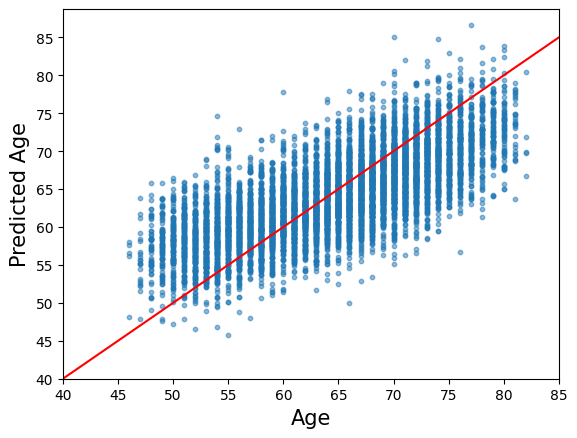

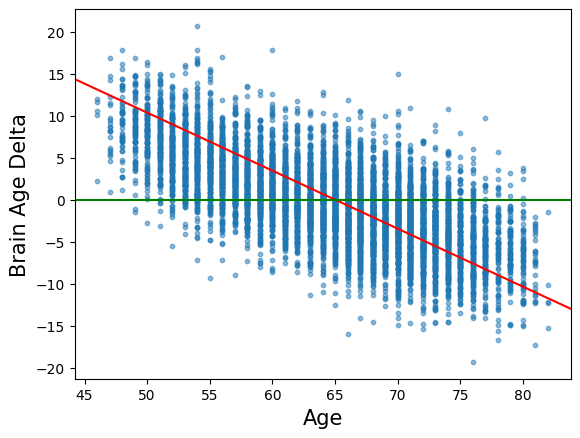

In [87]:
#plot figure with x: actual age Y: predicted age, and a line with slope 1 for reference
plt.figure()
plt.scatter(Y_test, y_pred_Ridge, alpha=0.5, s=10)
plt.axline((60,60), slope=1, color='r')
plt.xticks(range(40,90,5))
plt.yticks(range(40,90,5))
plt.ylabel('Predicted Age', fontsize = 15)
plt.xlabel('Age', fontsize = 15)
plt.show()

plt.figure()
plt.scatter(Y_test,brain_age_delta_Ridge, alpha=0.5, s=10)
plt.axline((65,0), slope=-0.69, color="r")
plt.axline((60,0),slope=0, color = "g")
plt.ylabel("Brain Age Delta", fontsize = 15)
plt.xlabel("Age", fontsize = 15)
plt.show()

### Brain Age Correction

Coefficient and Intercept: 0.5394718243964958 29.658905248303086


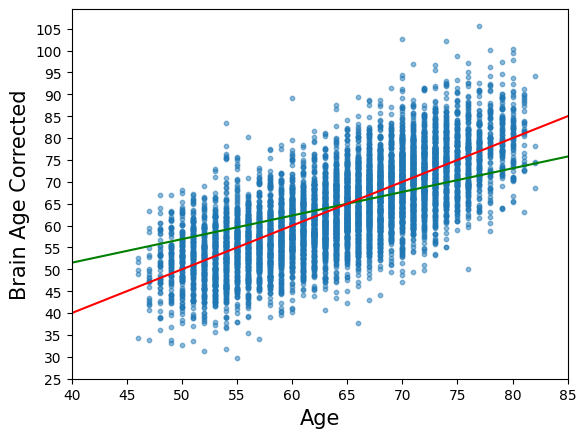

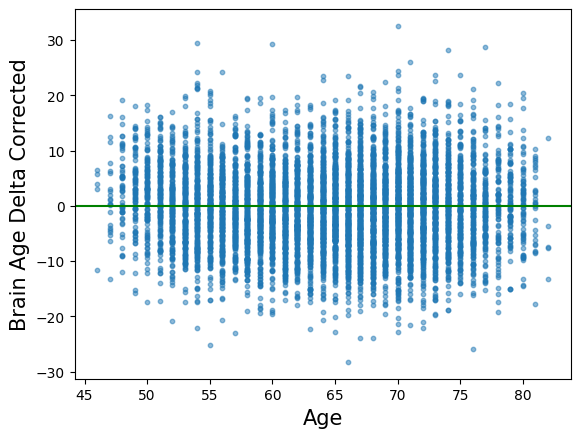

In [88]:
# reformat cross validation data for regression model
y_pred_cv = np.asarray(y_pred_cv)
y_pred_cv = np.reshape(y_pred_cv, (-1,1))
Y_test_cv = np.asarray(Y_test_cv)
Y_test_cv = np.reshape(Y_test_cv, (-1,1))

# now using correction from the R code that's online from Cole
reg = LinearRegression().fit(Y_test_cv, y_pred_cv)
coef = float(reg.coef_)
intercept = float(reg.intercept_)
print("Coefficient and Intercept:", coef, intercept)

# correction by cole
function = lambda t: (t-intercept)/coef
vfunc = np.vectorize(function)
corr_brainage_1 = vfunc(y_pred_Ridge)
corr_brainage_delta_1 = corr_brainage_1-Y_test


plt.figure()
plt.scatter(Y_test, corr_brainage_1, alpha=0.5, s=10)
plt.axline((65,65), slope=coef, color="g")
plt.ylabel("Brain Age Corrected", fontsize = 15)
plt.axline((60,60), slope=1, color='r')
plt.xlabel("Age", fontsize = 15)
plt.xticks(range(40,90,5))
plt.yticks(range(25,110,5))
plt.show()

plt.figure()
plt.scatter(Y_test, corr_brainage_delta_1, alpha=0.5, s=10)
plt.axline((60,0),slope=0, color = "g")
plt.ylabel("Brain Age Delta Corrected", fontsize = 15)
plt.xlabel("Age", fontsize = 15)
plt.show()

# 2. ASEG Segmentation

In [89]:
# select Freesurfer ASEG for training data
whole_brain = brain_train.iloc[:,27:70:2]
left_hemi = brain_train.iloc[:,103:134:2]
right_hemi = brain_train.iloc[:,165:196:2]
age = brain_train["Age"]
ASEG_train = pd.DataFrame(pd.concat([whole_brain,left_hemi, right_hemi,age],axis = 1))

# select Freesurfer ASEG for testing data
whole_brain = brain_test.iloc[:,27:70:2]
left_hemi = brain_test.iloc[:,103:134:2]
right_hemi = brain_test.iloc[:,165:196:2]
age = brain_test["Age"]
ASEG_test = pd.DataFrame(pd.concat([whole_brain,left_hemi, right_hemi,age],axis = 1))

X_train = ASEG_train.iloc[:,:-1]
Y_train = ASEG_train.iloc[:,-1]
X_test = ASEG_test.iloc[:,:-1]
Y_test = ASEG_test.iloc[:,-1]

# standardize x-data
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.fit_transform(X_test)

# model initialization - options to use Lasso, Ridge or SVM
#model = LassoCV(alphas = alpha_parameters, max_iter=100000)
#model = RidgeCV(alphas = alpha_parameters)
model = SVR(kernel = 'rbf')

# train model on training data
model.fit(X_train_std,Y_train)

# get predicted values for test set
y_pred = model.predict(X_test_std)

# calculate brain age gap
brain_age_delta = y_pred-Y_test

# get mean absolute error (MAE)
print("The MAE for testing set:", mean_absolute_error(Y_test,y_pred))



The MAE for testing set: 4.214068638528234


### Correction and Plots

Coefficient and Intercept: 0.5394718243964958 29.658905248303086


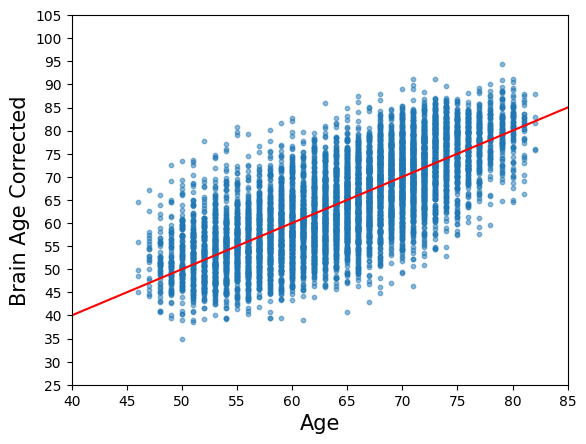

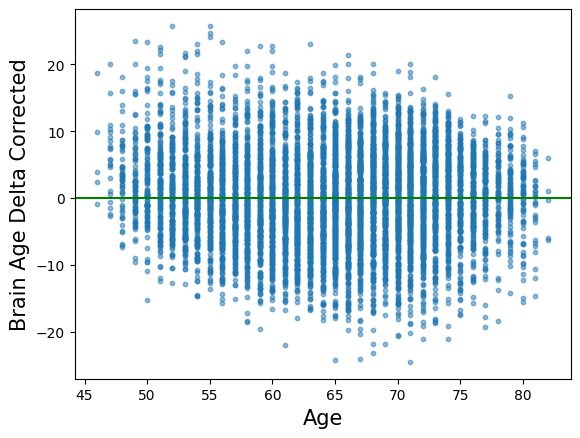

In [90]:
# reformat cross validation data for regression model
y_pred_cv = np.asarray(y_pred_cv)
y_pred_cv = np.reshape(y_pred_cv, (-1,1))
Y_test_cv = np.asarray(Y_test_cv)
Y_test_cv = np.reshape(Y_test_cv, (-1,1))

# now using correction from the R code that's online from Cole
reg = LinearRegression().fit(Y_test_cv, y_pred_cv)
coef = float(reg.coef_)
intercept = float(reg.intercept_)
print("Coefficient and Intercept:", coef, intercept)

# correction by cole
function = lambda t: (t-intercept)/coef
vfunc = np.vectorize(function)
corr_brainage_2 = vfunc(y_pred)
corr_brainage_delta_2 = corr_brainage_2-Y_test


plt.figure()
plt.scatter(Y_test, corr_brainage_2, alpha=0.5, s=10)
plt.ylabel("Brain Age Corrected", fontsize = 15)
plt.axline((60,60), slope=1, color='r')
plt.xlabel("Age", fontsize = 15)
plt.xticks(range(40,90,5))
plt.yticks(range(25,110,5))
plt.show()

plt.figure()
plt.scatter(Y_test, corr_brainage_delta_2, alpha=0.5, s=10)
plt.axline((60,0),slope=0, color = "g")
plt.ylabel("Brain Age Delta Corrected", fontsize = 15)
plt.xlabel("Age", fontsize = 15)
plt.show()

# 3. Desikan pial

The MAE for cross-validation (Ridge): 5.700505063026127
The MAE for testing set: 5.956385118925303


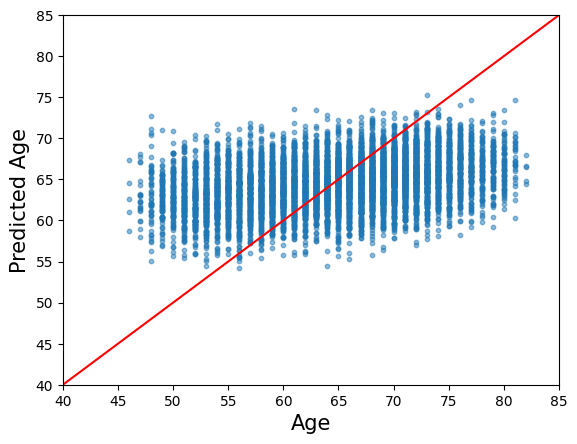

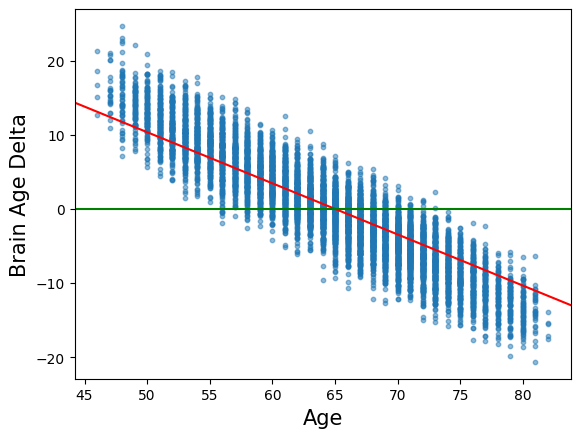

In [91]:



X_train = brain_train.iloc[:,845:976:2]
Y_train = brain_train.iloc[:,-1]
X_test = brain_test.iloc[:,845:976:2]
Y_test = brain_test.iloc[:,-1]

# standardize x-data
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.fit_transform(X_test)

# Cross validation
# cross validation on training set only -> select training set
X_CV = X_train_std
Y_CV = Y_train
# randomly split data (only training no PA) into training and testing set
X_train_cv, X_test_cv, Y_train_cv, Y_test_cvd = train_test_split(X_CV,Y_CV, random_state=8)
model = RidgeCV(alphas = alpha_parameters)
model.fit(X_train_cv,Y_train_cv)
y_pred_cvd = model.predict(X_test_cv)
delta_cvd = y_pred_cvd - Y_test_cvd
print("The MAE for cross-validation (Ridge):", mean_absolute_error(Y_test_cvd,y_pred_cvd))

# model initialization - options to use Lasso, Ridge or SVM
#model = LassoCV(alphas = alpha_parameters, max_iter=100000)
#model = RidgeCV(alphas = alpha_parameters)
model = SVR(kernel = 'rbf')

# train model on training data
model.fit(X_train_std,Y_train)

# get predicted values for test set
y_pred = model.predict(X_test_std)

# calculate brain age gap
brain_age_delta = y_pred-Y_test

# get mean absolute error (MAE)
print("The MAE for testing set:", mean_absolute_error(Y_test,y_pred))

plt.figure()
plt.scatter(Y_test, y_pred, alpha=0.5, s=10)
plt.axline((60,60), slope=1, color='r')
plt.xticks(range(40,90,5))
plt.yticks(range(40,90,5))
plt.ylabel('Predicted Age', fontsize = 15)
plt.xlabel('Age', fontsize = 15)
plt.show()

plt.figure()
plt.scatter(Y_test,brain_age_delta, alpha=0.5, s=10)
plt.axline((65,0), slope=-0.69, color="r")
plt.axline((60,0),slope=0, color = "g")
plt.ylabel("Brain Age Delta", fontsize = 15)
plt.xlabel("Age", fontsize = 15)
plt.show()

Coefficient and Intercept: 0.17271525612644412 53.21521911445886


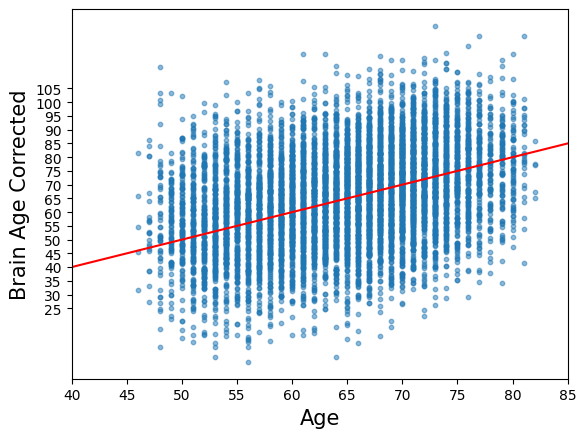

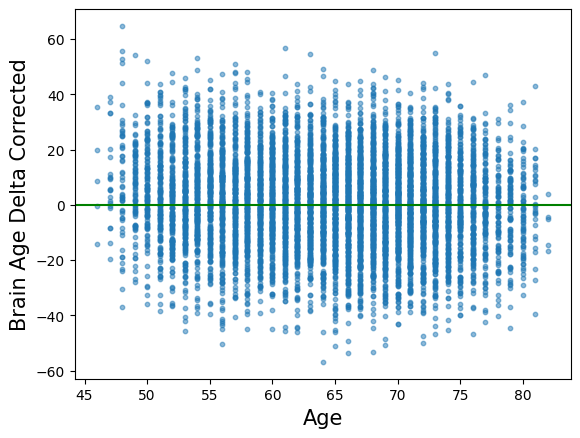

In [92]:
# reformat cross validation data for regression model
y_pred_cvd = np.asarray(y_pred_cvd)
y_pred_cvd = np.reshape(y_pred_cvd, (-1,1))
Y_test_cvd = np.asarray(Y_test_cvd)
Y_test_cvd = np.reshape(Y_test_cvd, (-1,1))

# now using correction from the R code that's online from Cole
reg = LinearRegression().fit(Y_test_cvd, y_pred_cvd)
coef = float(reg.coef_)
intercept = float(reg.intercept_)
print("Coefficient and Intercept:", coef, intercept)

# correction by cole
function = lambda t: (t-intercept)/coef
vfunc = np.vectorize(function)
corr_brainage_3 = vfunc(y_pred)
corr_brainage_delta_3 = corr_brainage_3-Y_test


plt.figure()
plt.scatter(Y_test, corr_brainage_3, alpha=0.5, s=10)
plt.ylabel("Brain Age Corrected", fontsize = 15)
plt.axline((60,60), slope=1, color='r')
plt.xlabel("Age", fontsize = 15)
plt.xticks(range(40,90,5))
plt.yticks(range(25,110,5))
plt.show()

plt.figure()
plt.scatter(Y_test, corr_brainage_delta_3, alpha=0.5, s=10)
plt.axline((60,0),slope=0, color = "g")
plt.ylabel("Brain Age Delta Corrected", fontsize = 15)
plt.xlabel("Age", fontsize = 15)
plt.show()

# 4. All Available brain variables

In [93]:
X_train = brain_train.iloc[:,1:2544:2]
Y_train = brain_train.iloc[:,-1]
X_test = brain_test.iloc[:,1:2544:2]
Y_test = brain_test.iloc[:,-1]

# standardize x-data
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.fit_transform(X_test)

# Cross validation
# cross validation on training set only -> select training set
X_CV = X_train_std
Y_CV = Y_train
# randomly split data (only training no PA) into training and testing set
X_train_cv, X_test_cv, Y_train_cv, Y_test_cvd = train_test_split(X_CV,Y_CV, random_state=8)
model = RidgeCV(alphas = alpha_parameters)
model.fit(X_train_cv,Y_train_cv)
y_pred_cv = model.predict(X_test_cv)
delta_cv = y_pred_cv - Y_test_cv
print("The MAE for cross-validation (Ridge):", mean_absolute_error(Y_test_cv,y_pred_cv))

# model initialization - options to use Lasso, Ridge or SVM
#model = LassoCV(alphas = alpha_parameters, max_iter=100000)
#model = RidgeCV(alphas = alpha_parameters)
model = SVR(kernel = 'rbf')

# train model on training data
model.fit(X_train_std,Y_train)

# get predicted values for test set
y_pred = model.predict(X_test_std)

# calculate brain age gap
brain_age_delta = y_pred-Y_test

# get mean absolute error (MAE)
print("The MAE for testing set:", mean_absolute_error(Y_test,y_pred))

The MAE for cross-validation (Ridge): 3.0647491156731594
The MAE for testing set: 3.560572074734664


Correction and plots

Coefficient and Intercept: 0.7473056979713857 16.18407704405324


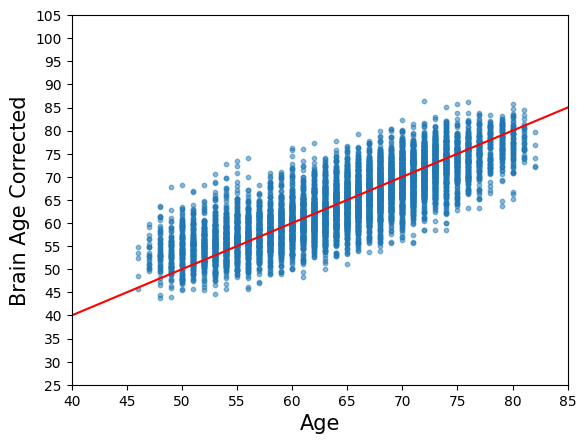

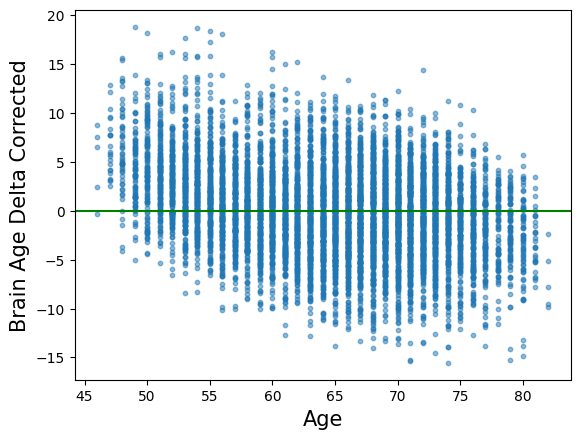

In [94]:
# reformat cross validation data for regression model
y_pred_cv = np.asarray(y_pred_cv)
y_pred_cv = np.reshape(y_pred_cv, (-1,1))
Y_test_cv = np.asarray(Y_test_cv)
Y_test_cv = np.reshape(Y_test_cv, (-1,1))

# now using correction from the R code that's online from Cole
reg = LinearRegression().fit(Y_test_cv, y_pred_cv)
coef = float(reg.coef_)
intercept = float(reg.intercept_)
print("Coefficient and Intercept:", coef, intercept)

# correction by cole
function = lambda t: (t-intercept)/coef
vfunc = np.vectorize(function)
corr_brainage_4 = vfunc(y_pred)
corr_brainage_delta_4 = corr_brainage_4-Y_test


plt.figure()
plt.scatter(Y_test, corr_brainage_4, alpha=0.5, s=10)
plt.ylabel("Brain Age Corrected", fontsize = 15)
plt.axline((60,60), slope=1, color='r')
plt.xlabel("Age", fontsize = 15)
plt.xticks(range(40,90,5))
plt.yticks(range(25,110,5))
plt.show()

plt.figure()
plt.scatter(Y_test, corr_brainage_delta_4, alpha=0.5, s=10)
plt.axline((60,0),slope=0, color = "g")
plt.ylabel("Brain Age Delta Corrected", fontsize = 15)
plt.xlabel("Age", fontsize = 15)
plt.show()

## Add brain Age predictions to main_test

In [95]:
main_test["BA A2009 Delta Corr"] = corr_brainage_delta_1
main_test["BA ASEG Delta Corr"] = corr_brainage_delta_2
main_test["BA Desikan Delta Corr"] = corr_brainage_delta_3
main_test["BA Delta Corr"] = corr_brainage_delta_4

Pickle data

In [96]:
# pickle results
main_test.to_pickle("3_main_test.pkl")
main_train.to_pickle("3_main_train.pkl")
brain_test.to_pickle("3_brain_test.pkl")
brain_train.to_pickle("3_brain_train.pkl")